# Heston and Black Scholes
In this ...
start with the imports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
from datetime import datetime

# contracts
from qablet_contracts.timetable import py_to_ts, TS_EVENT_SCHEMA
from qablet_contracts.eq.vanilla import Option

# models
from qablet.heston.mc import HestonMCModel
from qablet.black_scholes.mc import LVMCModel
from qablet.base.flags import Stats

## Common Dataset

In [ ]:
# Market Data
ticker = "SPX"
rate = 0.00  # 0.03
div = 0.00  # 0.01
spot = 100
pricing_dt = datetime(2023, 12, 31)

# flat array for discounts and forwards
tmax = 2.0
times = np.array([0.0, tmax])
rates = np.array([rate, rate])
fwds = spot * np.exp((rate - div) * times)

usd_crv = ("ZERO_RATES", np.column_stack((times, rates)))
fwds_crv = ("FORWARDS", np.column_stack((times, fwds)))
fwds_crv

('FORWARDS',
 array([[  0., 100.],
        [  2., 100.]]))

In [ ]:
# complete common dataset
dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(pricing_dt).value,
    "ASSETS": {
        "USD": usd_crv,
        ticker: fwds_crv,
    },
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 100,
        "SEED": 1,
    },
}

# Heston Model and Parameters
Let us define. See here for API. Keeping few things simple, such as, correlation is -100%, and initial variance is same as long variance.

In [ ]:
heston_model = HestonMCModel()

heston_dataset = dataset.copy()
heston_dataset["HESTON"] = {
    "ASSET": ticker,
    "INITIAL_VAR": 0.04,
    "LONG_VAR": 0.04,
    "MEANREV": 10,
    "VOL_OF_VAR": 1,
    "CORRELATION": -1.0,
}

## Black-Scholes Model
We will create the Black-Shcoles model object, and the dataset it requires here.

In [ ]:
bs_model = LVMCModel()

bs_dataset = dataset.copy()
bs_dataset["LV"] = {"ASSET": ticker, "VOL": 0.2}

### Price an ATM Option

In [ ]:
# array of 12 months, starting with princing date, ending with 1 year
mns = pd.bdate_range(pricing_dt, periods=13, freq="1ME")

timetable = Option("USD", ticker, spot, mns[12], False).timetable()
heston_price, _ = heston_model.price(timetable, heston_dataset)
bs_price, _ = bs_model.price(timetable, bs_dataset)
print(f"Heston: {heston_price:.2f}, BS: {bs_price:.2f}")

Heston: 7.47, BS: 8.02


### Price Options at different strikes and maturities

In [ ]:
df = pd.DataFrame(columns=["Maturity", "Strike", "Model", "Price"])
for m in [mns[6], mns[11], mns[12]]:
    for xr in [0.8, 0.9, 1, 1.1, 1.2]:  # % of the spot
        is_call = xr >= 1
        timetable = Option("USD", ticker, xr * spot, m, is_call).timetable()

        heston_price, _ = heston_model.price(timetable, heston_dataset)
        bs_price, _ = bs_model.price(timetable, bs_dataset)

        xr_str = f"{xr:.2f}/Call" if is_call else f"{xr:.2f}/Put"
        df.loc[len(df)] = [m, xr_str, "BS", bs_price]
        df.loc[len(df)] = [m, xr_str, "Heston", heston_price]

pd.options.display.float_format = "{:,.2f}".format
df.pivot(columns="Strike", index=["Maturity", "Model"], values="Price")

Strike             0.80/Put  0.90/Put  1.00/Call  1.10/Call  1.20/Call
Maturity   Model                                                      
2024-06-30 BS          0.31      1.77       5.59       2.19       0.70
           Heston      0.81      2.15       5.15       1.02       0.03
2024-11-30 BS          1.04      3.33       7.62       3.97       1.91
           Heston      1.65      3.61       7.12       2.75       0.61
2024-12-31 BS          1.21      3.63       7.96       4.30       2.16
           Heston      1.81      3.87       7.48       3.08       0.81

## Forward Distribution

In [ ]:
# We will define a forward timetable, instead of using contract classes from qablet_contracts
events = [
    {
        "track": "",
        "time": mns[12],
        "op": "+",
        "quantity": 1,
        "unit": ticker,
    }
]

events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
fwd_timetable = {"events": events_table, "expressions": {}}
print(fwd_timetable["events"].to_pandas())

  track                      time op  quantity unit
0       2024-12-31 00:00:00+00:00  +      1.00  SPX


In [ ]:
heston_dataset["MC"]["FLAGS"] = Stats.CASHFLOW
bs_dataset["MC"]["FLAGS"] = Stats.CASHFLOW

BS:    99.94 Heston:   100.00


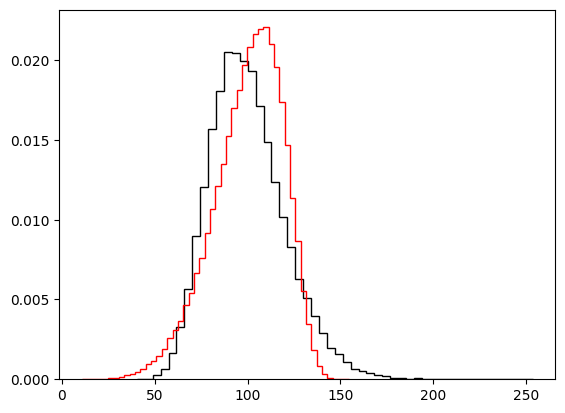

In [ ]:
heston_price, heston_stats = heston_model.price(fwd_timetable, heston_dataset)
bs_price, bs_stats = bs_model.price(fwd_timetable, bs_dataset)
print(f"BS: {bs_price: 8.2f} Heston: {heston_price: 8.2f}")
ev_idx = 0  # index of the event in the timetable that has cashflow

for color, stats in zip(["black", "red"], [bs_stats, heston_stats]):
    plt.hist(
        stats["CASHFLOW"][0][ev_idx],
        bins=50,
        color=color,
        histtype="step",
        density=True,
    )